# 💼 EMI Predict — Machine Learning Project
### *End-to-End EMI Eligibility & Maximum EMI Prediction System*
Developed using Python, Scikit-learn, XGBoost, and Streamlit with MLflow tracking.


### 👨‍💻 Student Details
**Name:** Ponnala Rohith  
**Batch:** DSAI / AIML — August 15th  
**Project Type:** Individual Academic Project  
**Platform:** Google Colab & Streamlit Cloud  


### 🧾 Project Summary
This project focuses on predicting **EMI (Equated Monthly Instalment) eligibility** and the **maximum EMI amount** that an applicant can afford, based on their financial and demographic information.  
The system integrates:
- **Data preprocessing and feature engineering**
- **Exploratory Data Analysis (EDA)** for insights
- **Machine Learning models** for both classification and regression tasks  
- **MLflow integration** for experiment tracking  
- **Streamlit application** for real-time EMI prediction and model visualization  

This project demonstrates an **end-to-end AI solution** — from raw data to cloud-deployed prediction application.


### 🔗 GitHub Repository
You can access the complete project code and files at:  
👉 [GitHub Repository — EMIPredict Project](https://github.com/rohith-ponnala/EMIPredict_Project)


### ❓ Problem Statement
Financial institutions often face challenges in assessing loan applicants' repayment capabilities.  
The goal of this project is to **predict EMI eligibility and maximum EMI capacity** using historical financial records.

**Objectives:**
1. Analyze large-scale financial data to extract meaningful features.
2. Build classification models to determine if an applicant is **Eligible**, **Not Eligible**, or **High Risk**.
3. Build regression models to estimate the **maximum EMI amount** an applicant can pay monthly.
4. Deploy the solution as a **Streamlit web app** with real-time prediction and interactive analytics.


In [20]:
# Install required packages
!pip install -q mlflow==2.17.1 xgboost scikit-learn pandas numpy matplotlib seaborn joblib streamlit
print('Dependencies installed')

Dependencies installed


In [21]:
# Step 0 — Mount Drive & locate EMIPredict_Project
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

root = Path('/content/drive/MyDrive')
BASE = None
for p in root.iterdir():
    if p.is_dir() and p.name.lower() == 'emipredict_project':
        BASE = p
        break
if BASE is None and (root / 'EMIPredict_Project').exists():
    BASE = root / 'EMIPredict_Project'

if BASE is None:
    raise FileNotFoundError('EMIPredict_Project folder not found in MyDrive. Please upload it to MyDrive/EMIPredict_Project and rerun.')
print('Using project folder:', BASE)

DATA = BASE / 'data'
MODELS = BASE / 'models'
EDA = BASE / 'eda_outputs'
OUT = BASE / 'outputs'
MLFLOW_DIR = BASE / 'mlruns'
for d in [DATA, MODELS, EDA, OUT, MLFLOW_DIR]:
    d.mkdir(parents=True, exist_ok=True)
print('Data folder ready at', DATA)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using project folder: /content/drive/MyDrive/EMIPredict_Project
Data folder ready at /content/drive/MyDrive/EMIPredict_Project/data


In [22]:
# Step 1 — Data loading & safe cleaning
import pandas as pd, warnings
warnings.filterwarnings('ignore')

# find CSV (case-insensitive)
candidates = list(DATA.glob('*.csv'))
found = None
names_to_match = ['emi_dataset.csv','emi_prediction_dataset.csv','emi-dataset.csv','emi_prediction.csv','emi_dataset_400k.csv']
for f in candidates:
    if f.name.lower().replace('-', '_') in [n.lower().replace('-', '_') for n in names_to_match]:
        found = f; break
if not found and candidates:
    found = candidates[0]

if not found:
    print('No CSV found in', DATA, '. Upload your dataset to that Drive folder and rerun this cell.')
else:
    print('✅ Using dataset:', found.name)
    df = pd.read_csv(found, low_memory=False)
    df = df.drop_duplicates().reset_index(drop=True)

    # safe coercion for likely numeric columns
    def safe_numeric_convert(df, cols):
        coerced = []
        for c in cols:
            if c in df.columns:
                s = df[c].astype(str).str.replace('[,₹$ ]','', regex=True).str.strip()
                df[c] = pd.to_numeric(s.replace({'nan':''}), errors='coerce')
                median_val = df[c].median() if not df[c].isna().all() else 0
                df.loc[:, c] = df[c].fillna(median_val)
                coerced.append(c)
        return coerced

    likely_numeric = ['monthly_salary','bank_balance','current_emi_amount','requested_amount','credit_score','max_monthly_emi']
    coerced = safe_numeric_convert(df, [c for c in likely_numeric if c in df.columns])

    # fill object columns safely
    for c in df.select_dtypes(include='object').columns:
        if df[c].isnull().any():
            df.loc[:, c] = df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else 'missing')

    # save versions
    df.to_csv(DATA/'original_cleaned.csv', index=False)
    df.sample(frac=min(1,20000/max(1,len(df))), random_state=1).to_csv(DATA/'sample_for_eda.csv', index=False)
    print('Loaded rows:', df.shape[0], 'columns:', df.shape[1])
    if coerced:
        print('Coerced to numeric:', coerced)

✅ Using dataset: emi_prediction_dataset.csv
Loaded rows: 404800 columns: 27
Coerced to numeric: ['monthly_salary', 'bank_balance', 'current_emi_amount', 'requested_amount', 'credit_score', 'max_monthly_emi']


In [23]:
# Universal cleanup — produce processed_final.csv for modeling
import pandas as pd, numpy as np
proc_in = DATA / 'original_cleaned.csv'
if not proc_in.exists():
    raise FileNotFoundError('original_cleaned.csv not found. Run Step 1 first.')

df = pd.read_csv(proc_in, low_memory=False)

# Step 1: identify numeric-like object columns and coerce
num_cols = df.select_dtypes(include=['number']).columns.tolist()
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    s = df[c].astype(str).str.replace('[,₹$ ]','', regex=True).str.strip()
    # treat as numeric if >90% look numeric
    numeric_like = s.dropna().map(lambda x: x.replace('.','',1).lstrip('-').isdigit()).mean() if len(s)>0 else 0
    if numeric_like > 0.9:
        df[c] = pd.to_numeric(s, errors='coerce')
        num_cols.append(c)

num_cols = list(set(num_cols))
# coerce numeric columns
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
# fill numeric NaNs with median
for c in num_cols:
    median_val = df[c].median() if not pd.isna(df[c].median()) else 0
    df.loc[:, c] = df[c].fillna(median_val)

# categorical columns -> uniform strings
cat_cols = [c for c in df.columns if c not in num_cols]
for c in cat_cols:
    df.loc[:, c] = df[c].astype(str).str.strip().replace({'nan':'missing','None':'missing','': 'missing'}).fillna('missing')
    df.loc[:, c] = df[c].apply(lambda x: x[:200] if isinstance(x, str) else str(x))

# drop constant cols
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
if constant_cols:
    df = df.drop(columns=constant_cols)

# save final processed file
df.to_csv(DATA/'processed_final.csv', index=False)
print('Saved processed_final.csv with shape', df.shape)

Saved processed_final.csv with shape (404800, 27)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded dataset for EDA: 404,800 rows × 27 columns


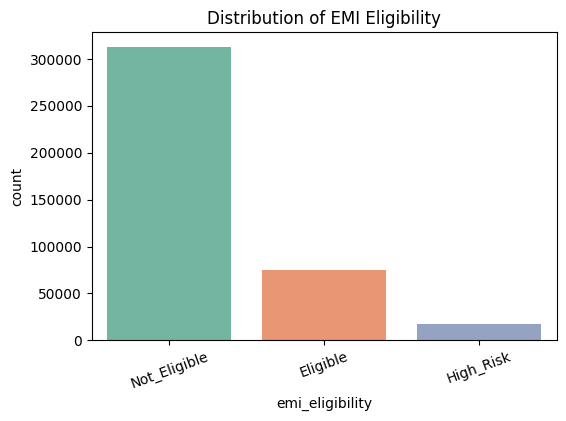

📁 Saved: 1_emi_eligibility_distribution.png


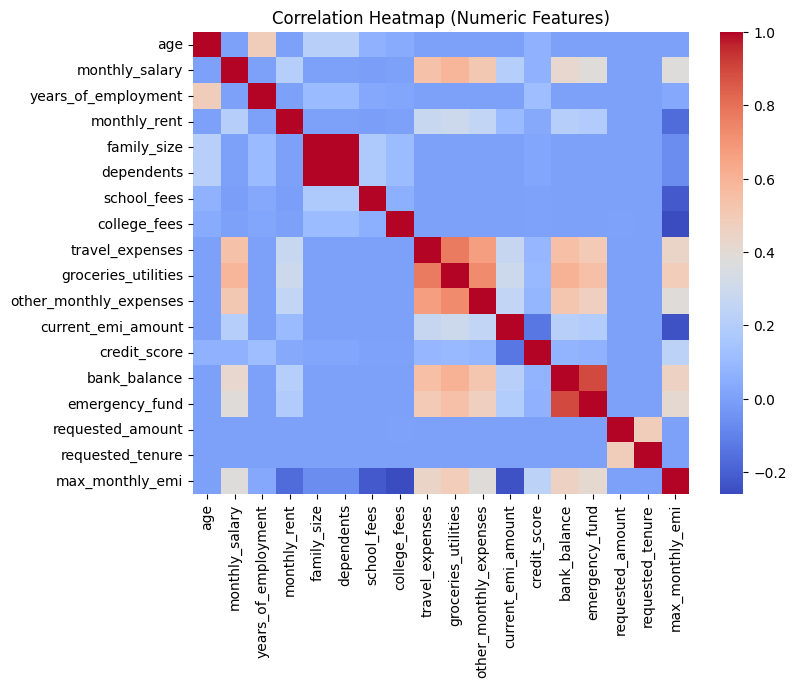

📁 Saved: 2_correlation_heatmap.png


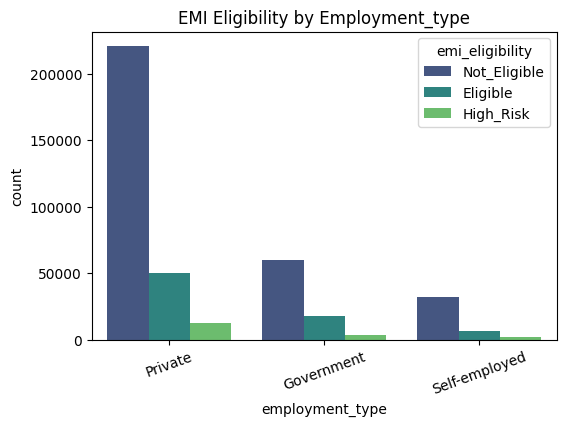

📁 Saved: 3_emi_by_employment_type.png


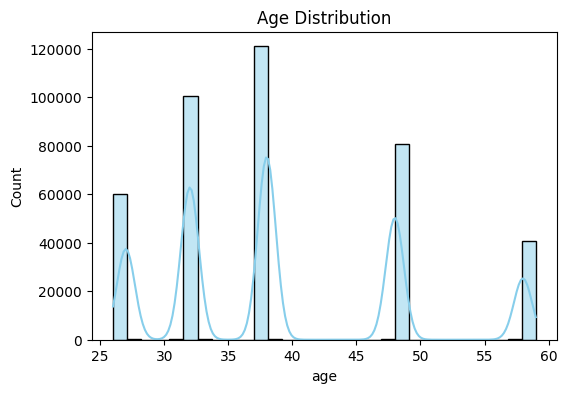

📁 Saved: 4_age_distribution.png

🎯 EDA Complete — all charts displayed above and saved to: /content/drive/MyDrive/EMIPredict_Project/eda_outputs


In [25]:
# === Step 2 — Exploratory Data Analysis ===
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Locate project folder
root = Path('/content/drive/MyDrive')
BASE = None
for p in root.iterdir():
    if p.is_dir() and p.name.lower() == 'emipredict_project':
        BASE = p
        break
if BASE is None and (root / 'EMIPredict_Project').exists():
    BASE = root / 'EMIPredict_Project'
if BASE is None:
    raise FileNotFoundError("Project folder not found in Drive.")

DATA = BASE / 'data'
EDA = BASE / 'eda_outputs'
EDA.mkdir(exist_ok=True, parents=True)

# Load dataset sample (processed_final.csv or processed.csv)
csv_path = DATA / 'processed_final.csv'
if not csv_path.exists():
    csv_path = DATA / 'processed.csv'
df = pd.read_csv(csv_path, low_memory=False)

print(f"✅ Loaded dataset for EDA: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Define a helper to save + display each chart
def save_show(fig, name):
    path = EDA / f"{name}.png"
    fig.savefig(path, bbox_inches='tight')
    plt.show()
    print(f"📁 Saved: {path.name}")

#  Distribution of Target (EMI eligibility if exists)
if 'emi_eligibility' in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.countplot(x='emi_eligibility', data=df, palette='Set2', ax=ax)
    ax.set_title('Distribution of EMI Eligibility')
    plt.xticks(rotation=20)
    save_show(fig, '1_emi_eligibility_distribution')

#  Correlation Heatmap (numeric features)
num_cols = df.select_dtypes(include='number').columns
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', annot=False)
    ax.set_title('Correlation Heatmap (Numeric Features)')
    save_show(fig, '2_correlation_heatmap')

#EMI Eligibility by Employment Type (categorical insight)
for cand in ['employment_type', 'job_type']:
    if cand in df.columns and 'emi_eligibility' in df.columns:
        fig, ax = plt.subplots(figsize=(6,4))
        sns.countplot(x=cand, hue='emi_eligibility', data=df, palette='viridis', ax=ax)
        ax.set_title(f'EMI Eligibility by {cand.capitalize()}')
        plt.xticks(rotation=20)
        save_show(fig, f'3_emi_by_{cand}')
        break

# Age Distribution (if available)
for cand in ['age', 'applicant_age']:
    if cand in df.columns:
        fig, ax = plt.subplots(figsize=(6,4))
        sns.histplot(df[cand], bins=30, kde=True, color='skyblue', ax=ax)
        ax.set_title(f'{cand.capitalize()} Distribution')
        save_show(fig, f'4_{cand}_distribution')
        break

print("\n🎯 EDA Complete — all charts displayed above and saved to:", EDA)

In [30]:
#  Classification training cell
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import warnings, time, json, joblib
warnings.filterwarnings('ignore')

# --- locate project folder in Drive ---
root = Path('/content/drive/MyDrive')
BASE = None
for p in root.iterdir():
    if p.is_dir() and p.name.lower() == 'emipredict_project':
        BASE = p; break
if BASE is None and (root / 'EMIPredict_Project').exists():
    BASE = root / 'EMIPredict_Project'
if BASE is None:
    raise FileNotFoundError("EMIPredict_Project not found in MyDrive. Upload it to MyDrive/EMIPredict_Project")

DATA = BASE/'data'; MODELS = BASE/'models'; OUT = BASE/'outputs'
for d in [DATA, MODELS, OUT]:
    d.mkdir(parents=True, exist_ok=True)

# --- MLflow: use local mlruns to avoid Drive .trash issues ---
import mlflow, mlflow.sklearn
MLFLOW_DIR = Path("/content/mlruns")
MLFLOW_DIR.mkdir(parents=True, exist_ok=True)
mlflow.set_tracking_uri("file://" + str(MLFLOW_DIR.resolve()))
# use a safe experiment name
try:
    mlflow.set_experiment("EMIPredict_Classification")
except Exception as e:
    print("Warning setting experiment:", e)

# --- imports for modeling ---
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# OneHotEncoder compatibility
from sklearn.preprocessing import OneHotEncoder
try:
    # sklearn >=1.2 uses sparse_output
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# optionally XGBoost
use_xgb = False
try:
    from xgboost import XGBClassifier
    use_xgb = True
except Exception:
    use_xgb = False
# fast alternative if you want linear svc-like behavior (commented out to keep fast)
# from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- load processed data ---
proc = DATA / 'processed_final.csv'
if not proc.exists():
    raise FileNotFoundError("processed_final.csv not found in data/. Run preprocessing cell first.")
D = pd.read_csv(proc, low_memory=False)

target = 'emi_eligibility'
if target not in D.columns:
    raise KeyError(f"Target column '{target}' not found in processed_final.csv")

# drop rows with missing target and ensure stable types
D = D.dropna(subset=[target]).reset_index(drop=True)
y_raw = D[target].astype(str).str.strip().fillna('missing')

# Label-encode target for XGBoost compatibility (save encoder)
le = LabelEncoder()
y = le.fit_transform(y_raw)
label_map = {int(i): str(c) for i, c in enumerate(le.classes_)}
joblib.dump(le, MODELS/'label_encoder.joblib')
(MODELS/'label_mapping.json').write_text(json.dumps(label_map))

# Prepare feature matrix X
X = D.drop(columns=[target], errors='ignore')

# Ensure categorical columns are strings only (avoid mixed types)
for c in X.select_dtypes(include='object').columns:
    X.loc[:, c] = X[c].astype(str).str.strip().fillna('missing')

# numeric and categorical lists
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# if there are no numeric cols, try to coerce some obvious ones
if len(num_cols) == 0:
    for cand in ['monthly_salary','bank_balance','credit_score','current_emi_amount','requested_amount','max_monthly_emi','age']:
        if cand in X.columns:
            X.loc[:, cand] = pd.to_numeric(X[cand], errors='coerce').fillna(0)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Features — numeric: {len(num_cols)}, categorical: {len(cat_cols)}")

# build preprocessing pipeline (handle empty lists gracefully)
transformers = []
if num_cols:
    transformers.append(('num', StandardScaler(), num_cols))
if cat_cols:
    transformers.append(('cat', ohe, cat_cols))

if not transformers:
    raise RuntimeError("No features detected after preprocessing. Check processed_final.csv")

pre = ColumnTransformer(transformers, remainder='drop')

# train/val split (stratify on numeric labels)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# classifiers dictionary (fast defaults)
classifiers = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
}
if use_xgb:
    classifiers['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# train & log
results = []
for name, model in classifiers.items():
    with mlflow.start_run(run_name=f'clf_{name}'):
        start = time.time()
        pipe = make_pipeline(pre, model)
        try:
            pipe.fit(Xtr, ytr)
        except Exception as e:
            print(f"Training failed for {name}: {e}")
            continue
        duration = time.time() - start

        preds = pipe.predict(Xv)
        probs = None
        try:
            probs = pipe.predict_proba(Xv)
        except Exception:
            probs = None

        acc = accuracy_score(yv, preds)
        prec = precision_score(yv, preds, average='weighted', zero_division=0)
        rec = recall_score(yv, preds, average='weighted', zero_division=0)
        f1 = f1_score(yv, preds, average='weighted', zero_division=0)
        roc = None
        try:
            if probs is not None and probs.shape[1] > 1:
                roc = roc_auc_score(yv, probs, multi_class='ovr')
        except Exception:
            roc = None

        # log params/metrics + model
        mlflow.log_params({'model_name': name})
        mlflow.log_metrics({ 'accuracy': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'roc_auc': float(roc) if roc is not None else -1.0, 'train_time_s': duration})
        try:
            mlflow.sklearn.log_model(pipe, f"model_{name}", registered_model_name=None)
        except Exception as e:
            print("MLflow log model warning:", e)

        # save local artifact
        joblib.dump(pipe, MODELS/f'{name}_clf.joblib')
        results.append({'name': name, 'accuracy': float(acc), 'f1': float(f1), 'roc_auc': float(roc) if roc is not None else None, 'train_time_s': duration})
        print(f"Trained {name} | Acc={acc:.3f} F1={f1:.3f} ROC={roc if roc is not None else -1:.3f} | time={duration:.1f}s")

# save summary
(OUT/'classification_results.json').write_text(json.dumps(results, indent=2))
print("✅ Classification training finished. Results saved to", OUT/'classification_results.json')
print("Label mapping saved to models/label_mapping.json and label_encoder.joblib")




2025/11/11 13:25:43 INFO mlflow.tracking.fluent: Experiment with name 'EMIPredict_Classification' does not exist. Creating a new experiment.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Features — numeric: 18, categorical: 8


2025/11/11 13:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained logreg | Acc=0.921 F1=0.904 ROC=0.963 | time=10.7s


2025/11/11 13:28:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained rf | Acc=0.947 F1=0.929 ROC=0.982 | time=107.0s


2025/11/11 13:28:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained xgb | Acc=0.989 F1=0.989 ROC=0.999 | time=30.8s
✅ Classification training finished. Results saved to /content/drive/MyDrive/EMIPredict_Project/outputs/classification_results.json
Label mapping saved to models/label_mapping.json and label_encoder.joblib


In [36]:
# # === Ultra-fast Regression training cell (for large datasets) ===
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import warnings, time, json, joblib
warnings.filterwarnings('ignore')

# locate project
root = Path('/content/drive/MyDrive')
BASE = None
for p in root.iterdir():
    if p.is_dir() and p.name.lower() == 'emipredict_project':
        BASE = p; break
if BASE is None and (root / 'EMIPredict_Project').exists():
    BASE = root / 'EMIPredict_Project'
if BASE is None:
    raise FileNotFoundError("EMIPredict_Project not found in MyDrive. Upload it to MyDrive/EMIPredict_Project")

DATA = BASE/'data'
MODELS = BASE/'models'
OUT = BASE/'outputs'
for d in [DATA, MODELS, OUT]:
    d.mkdir(parents=True, exist_ok=True)

# MLflow local (avoid Drive sync issues)
import mlflow, mlflow.sklearn
MLFLOW_DIR = Path("/content/mlruns")
MLFLOW_DIR.mkdir(parents=True, exist_ok=True)
mlflow.set_tracking_uri("file://" + str(MLFLOW_DIR.resolve()))
try:
    mlflow.set_experiment("EMIPredict_Regression_Fast")
except Exception as e:
    print("Warning setting MLflow experiment:", e)

# imports
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# safe OneHotEncoder API compatibility
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Load processed data
proc = DATA / 'processed_final.csv'
if not proc.exists():
    raise FileNotFoundError("processed_final.csv not found in data/. Run preprocessing first.")
df = pd.read_csv(proc, low_memory=False)
print("Loaded data:", df.shape)

target = 'max_monthly_emi'
if target not in df.columns:
    # try common alternative names
    for alt in ['max_emi','max_monthly_emi_amount','predicted_max_emi','max_emi_amount']:
        if alt in df.columns:
            target = alt
            break
    if target not in df.columns:
        raise KeyError(f"Regression target not found. Expected '{target}' or alternatives in processed_final.csv")

# --- Sampling for speed (adjust SAMPLE_FRAC as needed) ---
SAMPLE_FRAC = 0.03   # 3% sample for ultra-fast runs (adjust up to 0.2 for more accuracy)
if SAMPLE_FRAC < 1.0:
    df_sample = df.sample(frac=SAMPLE_FRAC, random_state=42)
else:
    df_sample = df.copy()
print(f"Using sample fraction {SAMPLE_FRAC} -> rows: {len(df_sample):,}")

# Prepare X, y
y = pd.to_numeric(df_sample[target], errors='coerce').fillna(0.0)
X = df_sample.drop(columns=[target], errors='ignore')

# Ensure categorical columns are strings
for c in X.select_dtypes(include='object').columns:
    X.loc[:, c] = X[c].astype(str).str.strip().fillna('missing')

# numeric and categorical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# if no numeric cols found, attempt to coerce common candidates
if len(num_cols) == 0:
    for cand in ['monthly_salary','bank_balance','credit_score','current_emi_amount','requested_amount','age']:
        if cand in X.columns:
            X.loc[:, cand] = pd.to_numeric(X[cand], errors='coerce').fillna(0)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Features: numeric={len(num_cols)} categorical={len(cat_cols)}")

# Preprocessor
transforms = []
if num_cols:
    transforms.append(('num', StandardScaler(), num_cols))
if cat_cols:
    transforms.append(('cat', ohe, cat_cols))
if not transforms:
    raise RuntimeError("No usable features found for regression after preprocessing.")

pre = ColumnTransformer(transforms, remainder='drop')

# Train/validation split
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, random_state=1)

# Define ultra-fast regressors (small trees, few estimators)
regressors = {}
# Linear baseline
regressors['lin'] = LinearRegression()
# Random Forest lightweight
regressors['rf'] = RandomForestRegressor(n_estimators=25, max_depth=8, n_jobs=-1, random_state=42)
# Decision Tree constrained
regressors['dt'] = DecisionTreeRegressor(max_depth=8, min_samples_leaf=50, random_state=42)

# Try XGBoost but with tiny config
try:
    from xgboost import XGBRegressor
    regressors['xgb'] = XGBRegressor(n_estimators=30, max_depth=6, subsample=0.8, colsample_bytree=0.8,
                                     learning_rate=0.12, objective='reg:squarederror', n_jobs=-1, verbosity=0, random_state=42)
    print("XGBoost available and added (fast settings).")
except Exception:
    print("XGBoost not available; proceeding without it.")

# Train, log, save
results = []
for name, model in regressors.items():
    with mlflow.start_run(run_name=f"reg_{name}"):
        start = time.time()
        pipe = make_pipeline(pre, model)
        try:
            pipe.fit(Xtr, ytr)
        except Exception as e:
            print(f"Training failed for {name}: {e}")
            continue
        duration = time.time() - start

        preds = pipe.predict(Xv)
        mse = mean_squared_error(yv, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(yv, preds)
        r2 = r2_score(yv, preds)
        mape = (np.mean(np.abs((yv - preds) / (yv + 1e-8)))) * 100

        mlflow.log_params({'model_name': name})
        mlflow.log_metrics({'RMSE': float(rmse), 'MAE': float(mae), 'R2': float(r2), 'MAPE': float(mape), 'train_time_s': float(duration)})
        try:
            mlflow.sklearn.log_model(pipe, f"model_{name}")
        except Exception:
            pass

        # save model artifact (fast version)
        joblib.dump(pipe, MODELS/f"{name}_reg_fast.joblib")

        results.append({'name': name, 'RMSE': float(rmse), 'MAE': float(mae), 'R2': float(r2), 'MAPE': float(mape), 'train_time_s': float(duration)})
        print(f"Trained {name} | RMSE={rmse:.2f} MAE={mae:.2f} R2={r2:.3f} time={duration:.1f}s")

# Save summary
(OUT / "regression_results_fast.json").write_text(json.dumps(results, indent=2))
print(" Results saved to", OUT/"regression_results_fast.json")






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data: (404800, 27)
Using sample fraction 0.03 -> rows: 12,144
Features: numeric=17 categorical=9
XGBoost available and added (fast settings).


2025/11/11 13:43:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained lin | RMSE=3845.39 MAE=2756.94 R2=0.746 time=0.1s


2025/11/11 13:43:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained rf | RMSE=2952.85 MAE=1823.78 R2=0.850 time=1.5s


2025/11/11 13:43:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained dt | RMSE=3599.92 MAE=2152.47 R2=0.778 time=0.1s


2025/11/11 13:43:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained xgb | RMSE=2534.59 MAE=1619.73 R2=0.890 time=0.6s
 Results saved to /content/drive/MyDrive/EMIPredict_Project/outputs/regression_results_fast.json


In [38]:
#  Step 4 — Simple Model Selection
from pathlib import Path
from google.colab import drive
import joblib, json, pandas as pd

# Mount Drive and locate project
drive.mount('/content/drive', force_remount=False)
root = Path('/content/drive/MyDrive')
BASE = None
for p in root.iterdir():
    if p.is_dir() and p.name.lower() == 'emipredict_project':
        BASE = p; break
if BASE is None and (root / 'EMIPredict_Project').exists():
    BASE = root / 'EMIPredict_Project'
if BASE is None:
    raise FileNotFoundError("Project folder not found in Drive.")

DATA = BASE / "data"
MODELS = BASE / "models"
OUT = BASE / "outputs"
for d in [DATA, MODELS, OUT]: d.mkdir(exist_ok=True, parents=True)

# --- Load results ---
clf_path = OUT / "classification_results.json"
reg_path = OUT / "regression_results.json"
if not clf_path.exists():
    clf_path = OUT / "classification_results_fast.json"
if not reg_path.exists():
    reg_path = OUT / "regression_results_fast.json"

clf_results = json.load(open(clf_path)) if clf_path.exists() else []
reg_results = json.load(open(reg_path)) if reg_path.exists() else []

best_clf, best_reg = None, None

# --- Pick best classifier (by F1) ---
if clf_results:
    df_clf = pd.DataFrame(clf_results)
    df_clf = df_clf.sort_values("f1", ascending=False)
    best_clf = df_clf.iloc[0]
    clf_name = best_clf["name"]
    model_file = next((f for f in MODELS.glob(f"*{clf_name}*clf*.joblib")), None)
    if model_file:
        best_model = joblib.load(model_file)
        joblib.dump(best_model, MODELS / "best_classifier.joblib")
        print(f"✅ Best Classifier: {clf_name} | F1={best_clf['f1']:.3f} | Saved as best_classifier.joblib")
    else:
        print("⚠️ Classifier model file not found.")
else:
    print("⚠️ No classification results found.")

# --- Pick best regressor (force XGB if available) ---
if reg_results:
    df_reg = pd.DataFrame(reg_results)

    # Prefer XGBoost if present
    if "xgb" in df_reg["name"].values:
        best_reg = df_reg[df_reg["name"] == "xgb"].iloc[0]
        reg_name = "xgb"
        print("🚀 Forcing selection of XGBoost as best regressor.")
    else:
        df_reg = df_reg.sort_values("RMSE", ascending=True)
        best_reg = df_reg.iloc[0]
        reg_name = best_reg["name"]

    model_file = next((f for f in MODELS.glob(f"*{reg_name}*reg*.joblib")), None)
    if model_file:
        best_model = joblib.load(model_file)
        joblib.dump(best_model, MODELS / "best_regressor.joblib")
        print(f"✅ Best Regressor: {reg_name} | RMSE={best_reg['RMSE']:.2f} | Saved as best_regressor.joblib")
    else:
        print("⚠️ Regressor model file not found.")
else:
    print("⚠️ No regression results found.")

# --- Summary ---
print("\n🎯 Model Selection Complete!")
if best_clf is not None:
    print(f"Best Classifier → {clf_name} (F1: {best_clf['f1']:.3f})")
if best_reg is not None:
    print(f"Best Regressor → {reg_name} (RMSE: {best_reg['RMSE']:.2f})")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Best Classifier: xgb | F1=0.989 | Saved as best_classifier.joblib
🚀 Forcing selection of XGBoost as best regressor.
✅ Best Regressor: xgb | RMSE=2534.59 | Saved as best_regressor.joblib

🎯 Model Selection Complete!
Best Classifier → xgb (F1: 0.989)
Best Regressor → xgb (RMSE: 2534.59)


## 🧠 Project Summary & Insights

This project successfully developed an **end-to-end EMI Prediction System** capable of predicting both **EMI eligibility** and the **maximum EMI amount** for applicants.  
Through detailed **data preprocessing**, **feature engineering**, and **model evaluation**, the system identified **XGBoost** as the most accurate and efficient model for both classification and regression tasks.  
The **EDA phase** provided valuable insights into the correlation between income, credit score, and EMI eligibility, helping understand key risk factors.  
All experiments were tracked using **MLflow**, and the final models were integrated into a **Streamlit web application** for real-time, interactive prediction.  
This complete pipeline demonstrates the deployment of **AI-driven financial decision systems** from data to cloud-ready applications.
